In [1]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs --break-system-packages
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO --break-system-packages

In [2]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO

In [3]:
# !pip install -e ../../objFuncs
# !pip install -e ../../pyBO

### This template is for
- objFuncs: v1.0.4  
- pyBO: v1.0.2

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import objFuncs
from objFuncs import VM, objFuncGoals, construct_machineIO
from objFuncs.util import plot_time_val, plot_obj_history
from objFuncs.preset import get_preset, get_tolerance, get_limits
from pyBO import pyBO

objFuncs version: 1.0.4. updated on 2024-03-26
flame_utils is not importable. ignoreing this feature...
pyBO version: 1.0.2. updated on 2024-03-26


In [6]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import time
import datetime
import concurrent
import pandas as pd

In [7]:
logfile = './log/20241124_0111[238U35][pyBO][MEBT]FC1102.json'

with open(logfile,'r') as f:
    data = json.load(f)

In [8]:
# data

# check machineIO, source and beam  

In [9]:
obj = objFuncGoals(load_from_file=logfile)

In [10]:
obj.history.keys()

dict_keys(['time', 'decision_CSETs', 'decision_RDs', 'objectives', 'objective_RDs'])

In [11]:
def reformat_obj_history_for_plotting(obj_history) :
    """
    Converts an obj.history dictionary to the "PV-centric" format 
    expected by plot_time_val (i.e., the machineIO.history format).
    
    This version parses ISO-formatted time strings.
    """
    if 'time' not in obj_history or not obj_history['time']:
        print("History is empty or does not contain 'time' data.")
        return {}

    times_raw = obj_history['time']
    times = []

    # --- MODIFIED SECTION ---
    # Check the type of the first timestamp to see if conversion is needed
    if times_raw and isinstance(times_raw[0], str):
        try:
            # Use fromisoformat for standard ISO strings
            times = [datetime.datetime.fromisoformat(t) for t in times_raw]
        except ValueError:
            # Fallback for slightly different formats if needed
            try:
                times = [datetime.datetime.strptime(t, '%Y-%m-%dT%H:%M:%S.%f') for t in times_raw]
            except Exception as e:
                print(f"Error parsing timestamps: {e}. Plot may be incorrect.")
                times = times_raw # Fallback to raw, though plotting will likely fail
        except Exception as e:
             print(f"Error parsing timestamps: {e}. Plot may be incorrect.")
             times = times_raw
    elif times_raw and isinstance(times_raw[0], datetime.datetime):
        times = times_raw # They are already datetime objects
    else:
        print("Warning: Time format not recognized as string or datetime.")
        times = times_raw
    # --- END OF MODIFIED SECTION ---

    reformatted_history = {}

    # List of keys that contain plottable PV/objective data
    data_keys = [
        'decision_CSETs', 
        'decision_RDs', 
        'objective_RDs', 
        'coupled_decision_CSETs',
        'objectives' # Also include calculated objectives
    ]

    for key in data_keys:
        if key in obj_history and 'names' in obj_history[key] and 'values' in obj_history[key]:
            try:
                names = obj_history[key]['names']
                all_values = np.array(obj_history[key]['values'])

                # Handle empty history
                if all_values.size == 0:
                    continue

                # Ensure 'all_values' is 2D
                if all_values.ndim == 1:
                   if len(names) == 1:
                       all_values = all_values.reshape(-1, 1)
                   else:
                       continue # Skip if 1D but multiple names

                # Check for shape mismatch
                if len(times) != all_values.shape[0]:
                    print(f"Warning: Skipping '{key}'. Mismatch between time steps ({len(times)}) and data steps ({all_values.shape[0]}).")
                    continue
                
                if len(names) != all_values.shape[1]:
                    print(f"Warning: Skipping '{key}'. Mismatch between names ({len(names)}) and data columns ({all_values.shape[1]}).")
                    continue

                for i, name in enumerate(names):
                    # Avoid overwriting (e.g., if a PV is in CSET and RD)
                    if name not in reformatted_history: 
                        values_for_this_pv = all_values[:, i]
                        reformatted_history[name] = {'t': times, 'v': values_for_this_pv.tolist()}
            
            except Exception as e:
                print(f"Warning: Could not process key '{key}'. Error: {e}")

    # Also add the 'total' objective if it exists
    if 'objectives' in obj_history and 'total' in obj_history['objectives']:
         if len(obj_history['objectives']['total']) == len(times):
            reformatted_history['Objective Total'] = {
                't': times,
                'v': obj_history['objectives']['total']
            }

    return reformatted_history

In [12]:
kdecisionRD = [
    [key for key in obj.decision_RDs if ':PSC_'   in key],   #obj is objFuncGoals instance
    [key for key in obj.decision_RDs if  'SOL_'   in key],
    [key for key in obj.decision_RDs if ':PSQ_'   in key],
    [key for key in obj.decision_RDs if ':PHASE_' in key],
]
kLefts  =  []
for key in obj.decision_RDs:
    isin = False
    for l in kdecisionRD:
        if key in l:
            isin = True
    if not isin:
        kLefts.append(key)
kdecisionRD.append(kLefts)
kdecisionRD = [l for l in kdecisionRD if len(l)>0]

# objective_RD keys   
kobjectiveRD = [
    [key for key in obj.objective_RDs if ':XPOS_' in key or ':YPOS_' in key],   #obj is objFuncGoals instance
    [key for key in obj.objective_RDs if ':PHASE_' in key],
    [key for key in obj.objective_RDs if ':MAG_' in key],
    [key for key in obj.objective_RDs if ':AVGPK_' in key or ':CURRENT_' in key or ':PKAVG_' in key],
]
kLefts  =  []
for key in obj.objective_RDs:
    isin = False
    for l in kobjectiveRD:
        if key in l:
            isin = True
    if not isin:
        kLefts.append(key)
kobjectiveRD.append(kLefts)
kobjectiveRD = [l for l in kobjectiveRD if len(l)>0]

plot_history = reformat_obj_history_for_plotting(obj.history)

# callbacks for plot
plot_callbacks = [plot_time_val(
                      history=plot_history,
                      keys = kdecisionRD + kobjectiveRD #+ kdecisionSET
                      ),
                  plot_obj_history(
                      obj.history['objectives'],
                      title = 'objectives',
                      add_y_data = obj.history['objectives']['total'],
                      add_y_label = 'total obj'
                      )
                 ] 

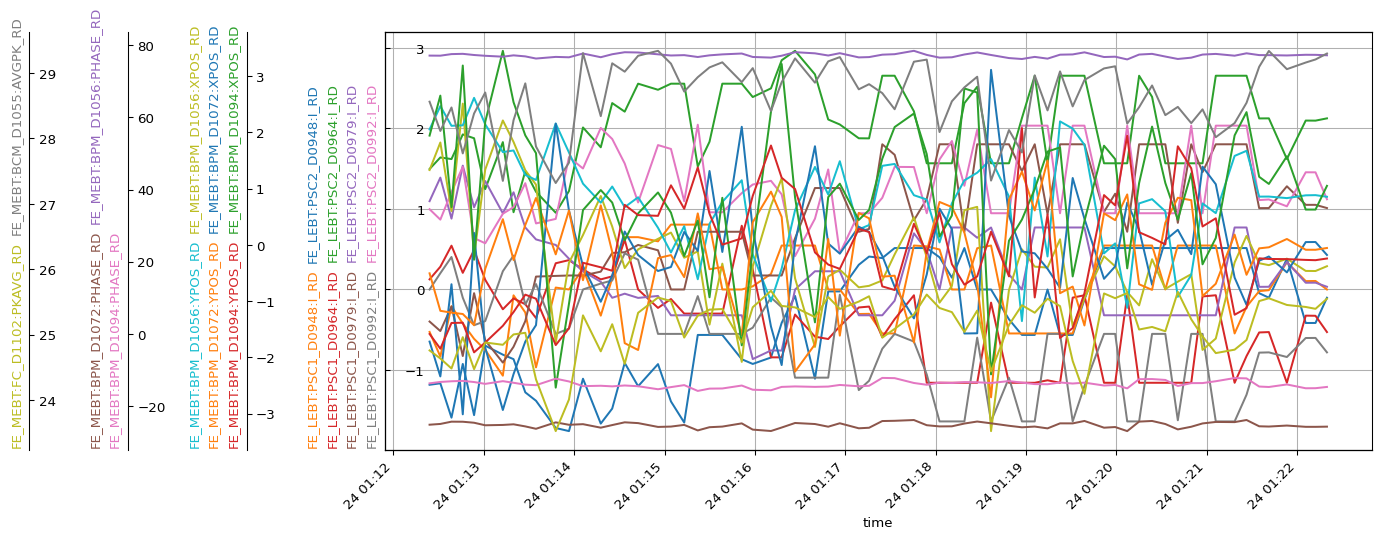

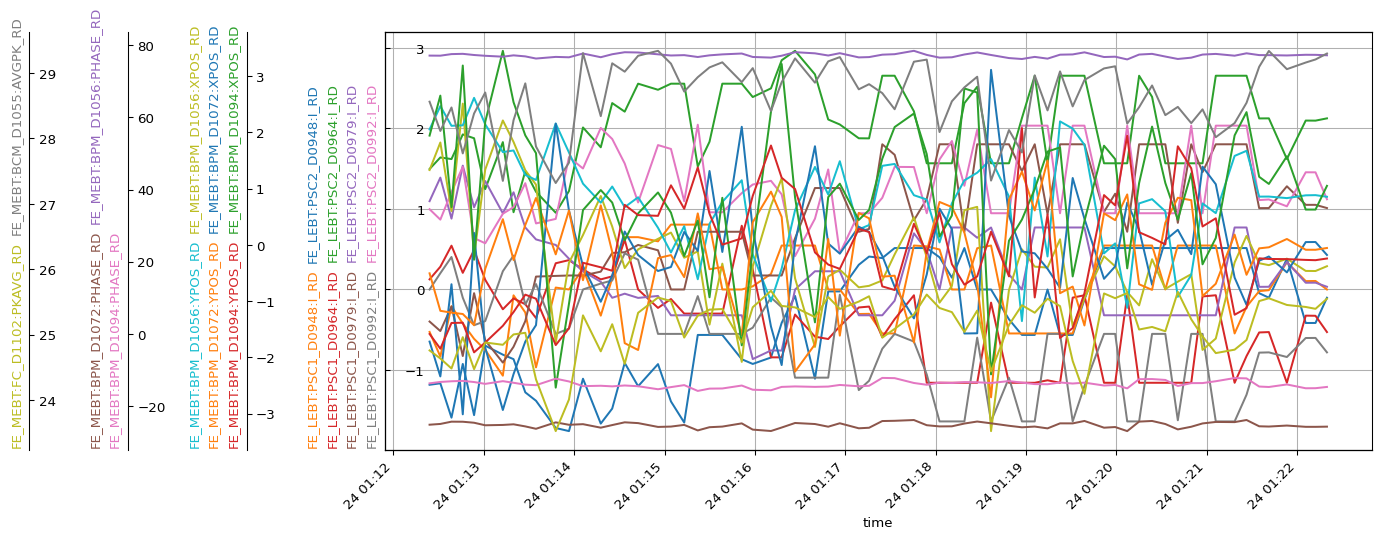

In [13]:
plot_callbacks[0]()

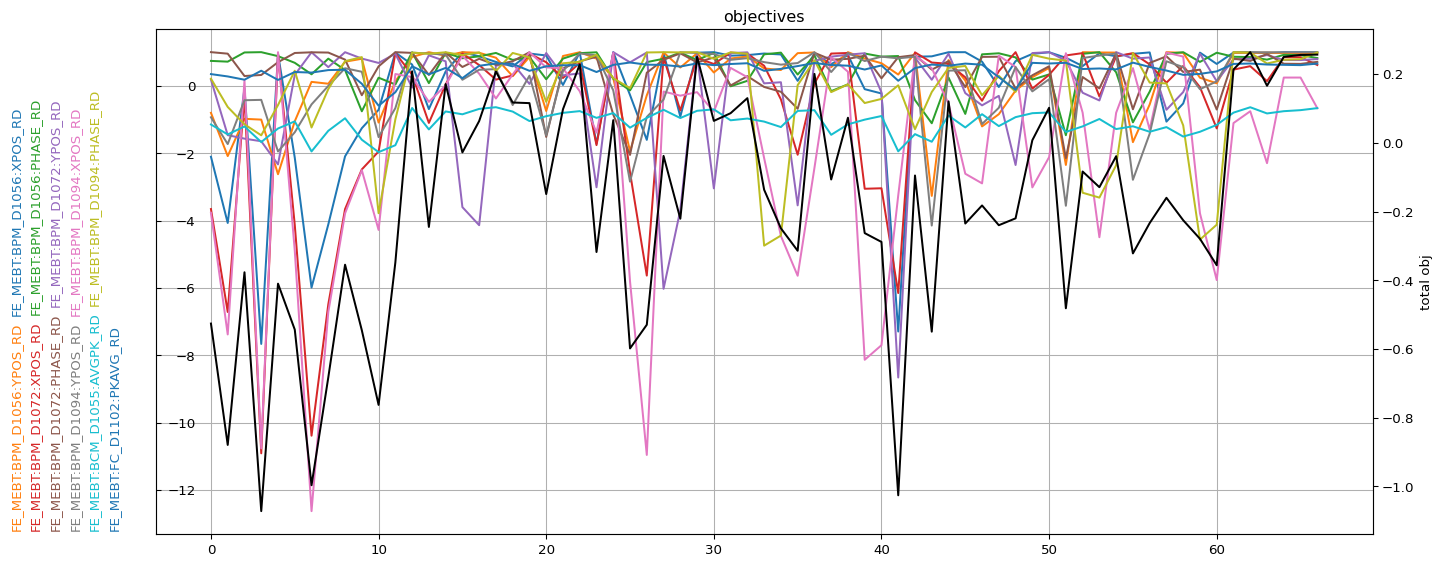

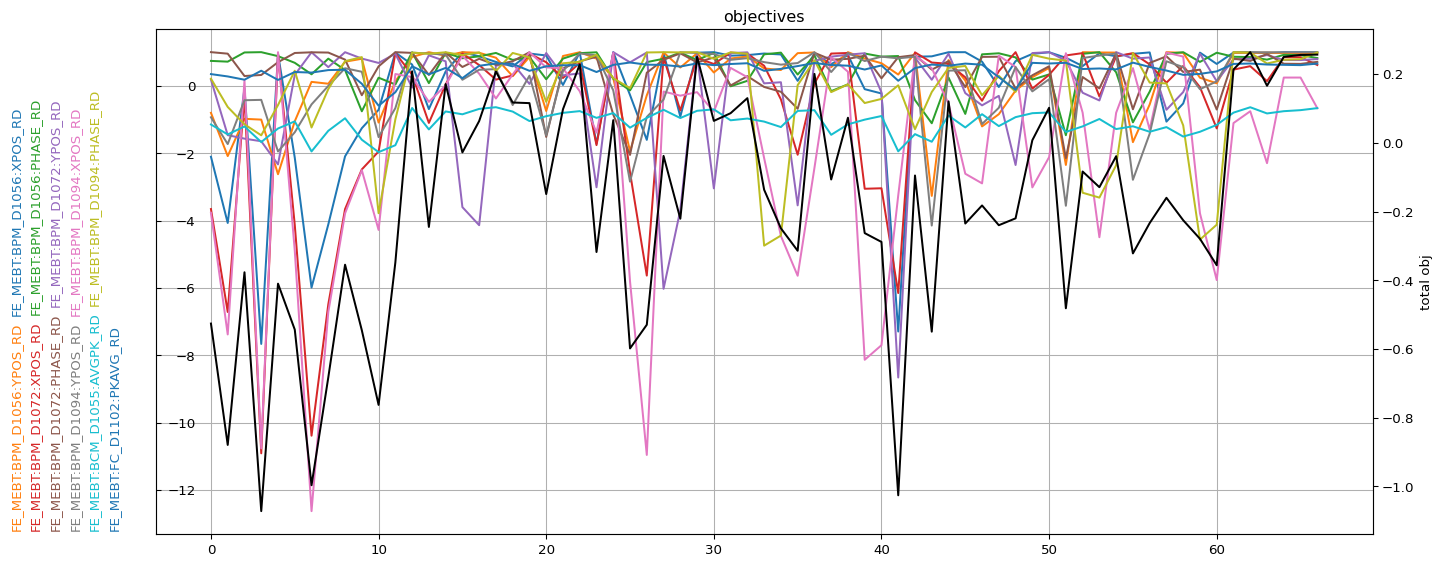

In [14]:
plot_callbacks[1]()

In [15]:
class plot_accumulated_best:
    """
    Plots the accumulated best (max) value of the total objective
    from an obj.history dictionary.
    """
    def __init__(self,
                 history, # Expects obj.history
                 inline = True,
                 hdisplay = None,
                 fig = None,
                 ax = None,
                 title = "Accumulated Best Objective",
                 xlabel = "Iteration",
                 ylabel = "Best Objective Value",
                ):
        
        if 'objectives' in history and 'total' in history['objectives']:
            self._history_ref = history['objectives'] # Store reference
        else:
            print("Warning: 'history['objectives']['total']' not found.")
            self._history_ref = {'total': []} # Empty placeholder
            
        self.inline = inline
        self.hdisplay = hdisplay
        self.fig = fig
        self.ax = ax
        self._plot_constructed = False
        self.title = title
        self.xlabel = xlabel
        self.ylabel = ylabel
        
    def _get_total_history(self):
        """Accesses the total history list via the reference."""
        return self._history_ref.get('total', [])
        
    def _calculate_accumulated_best(self):
        """Helper to compute cumulative max and iterations."""
        total_obj_history = self._get_total_history()
        if not total_obj_history:
            return np.array([]), np.array([])
            
        values = np.array(total_obj_history)
        accumulated_best = np.maximum.accumulate(values)
        iterations = np.arange(len(accumulated_best))
        return iterations, accumulated_best

    def _construct_plot(self,
                        hdisplay=None,
                        fig=None,
                        ax=None,
                        inline=None
                        ):        
        
        self.ax = ax or self.ax
        self.fig = fig or self.fig
        self.hdisplay = hdisplay or self.hdisplay
        inline = inline or self.inline
        
        if ax is None:
            self.fig, self.ax = plt.subplots(figsize=(4, 2.5), dpi=96)
            if inline and self.hdisplay is None:
                try:
                    self.hdisplay = display("", display_id=True)
                except Exception as e:
                    print(f"Warning: IPython.display not found or failed ({e}). Inline plotting may not update.")
                    self.hdisplay = None
        
        iterations, accumulated_best = self._calculate_accumulated_best()
        
        if iterations.size > 0:
            self.ax.plot(iterations, accumulated_best, marker='.', linestyle='-')
        
        self.ax.set_xlabel(self.xlabel)
        self.ax.set_ylabel(self.ylabel)
        self.ax.set_title(self.title)
        self.ax.grid(True)
        self.fig.tight_layout()
        
        if inline:
            if self.hdisplay:
                self.hdisplay.update(self.fig)
        else:
            self.fig.show()
            self.fig.canvas.draw()
            
        self._plot_constructed = True

    def _update_plot(self, inline=None):
        inline = inline or self.inline
        
        iterations, accumulated_best = self._calculate_accumulated_best()
        
        if iterations.size == 0:
            return # Nothing to plot
            
        if not self.ax.lines:
             # Line doesn't exist, just re-construct
             self._construct_plot(inline=inline)
             return

        line = self.ax.lines[0]
        line.set_xdata(iterations)
        line.set_ydata(accumulated_best)
            
        self.ax.relim()
        self.ax.autoscale_view()

        if inline:
            if self.hdisplay:
                self.hdisplay.update(self.fig)
        else:
            self.fig.show()
            self.fig.canvas.draw()
          
    def close(self):
        if self.fig:
            plt.close(self.fig)
        self._plot_constructed = False
            
    def __call__(self,
                hdisplay=None,
                fig=None,
                ax=None,
                inline=None,
                ):
        inline = inline or self.inline
        
        if not self._get_total_history():
            return # Don't plot if empty
        
        if self._plot_constructed:
            self._update_plot(inline=inline)
        else:
            self._construct_plot(
                hdisplay=hdisplay, 
                fig=fig, 
                ax=ax, 
                inline=inline
            )

In [16]:
plot_best = plot_accumulated_best(obj.history)

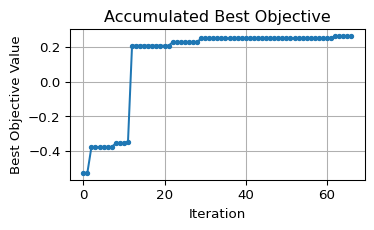

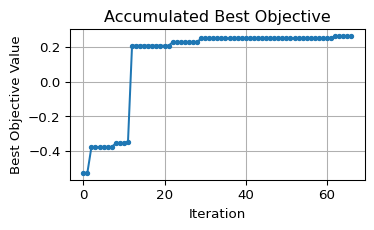

In [17]:
plot_best()

In [18]:
def simplify_label(name):
    # 1. Remove prefix and suffix
    n = name.replace("FE_MEBT:", "").replace("_RD", "")
    
    # 2. Split into device and field
    if ":" in n:
        dev, field = n.split(":", 1)
    else:
        dev, field = n, ""
    
    field_up = field.upper()
    
    # 3. Determine unit and standardized display
    if field_up in ["XPOS", "YPOS"]:
        unit = "(mm)"
        field_clean = field_up
    elif field_up == "PHASE":
        unit = "(deg)"
        field_clean = field_up
    elif field_up in ["AVGPK", "PKAVG"]:
        # Requested: change AVGPK → PKAVG
        unit = "(uA)"
        field_clean = "PKAVG"
    else:
        # default case
        unit = ""
        field_clean = field_up
    
    return f"{dev} {field_clean} {unit}".strip()



Summary (final relative to goal):
FE_MEBT:BPM_D1056:XPOS_RD                 final-goal =  +0.0522   tol =      1   WITHIN TOL
FE_MEBT:BPM_D1056:YPOS_RD                 final-goal =  +0.1445   tol =      1   WITHIN TOL
FE_MEBT:BPM_D1056:PHASE_RD                final-goal =  -0.4185   tol =      1   WITHIN TOL
FE_MEBT:BPM_D1072:XPOS_RD                 final-goal =  -0.6175   tol =      1   WITHIN TOL
FE_MEBT:BPM_D1072:YPOS_RD                 final-goal =  -0.4527   tol =      1   WITHIN TOL
FE_MEBT:BPM_D1072:PHASE_RD                final-goal =  -0.5371   tol =      1   WITHIN TOL
FE_MEBT:BPM_D1094:XPOS_RD                 final-goal =    +1.29   tol =      1   OUTSIDE TOL
FE_MEBT:BPM_D1094:YPOS_RD                 final-goal = -0.04846   tol =      1   WITHIN TOL
FE_MEBT:BPM_D1094:PHASE_RD                final-goal =  -0.1063   tol =      1   WITHIN TOL
FE_MEBT:BCM_D1055:AVGPK_RD                final-goal =   -1.003   tol =  1.515   WITHIN TOL
FE_MEBT:FC_D1102:PKAVG_RD                 fin

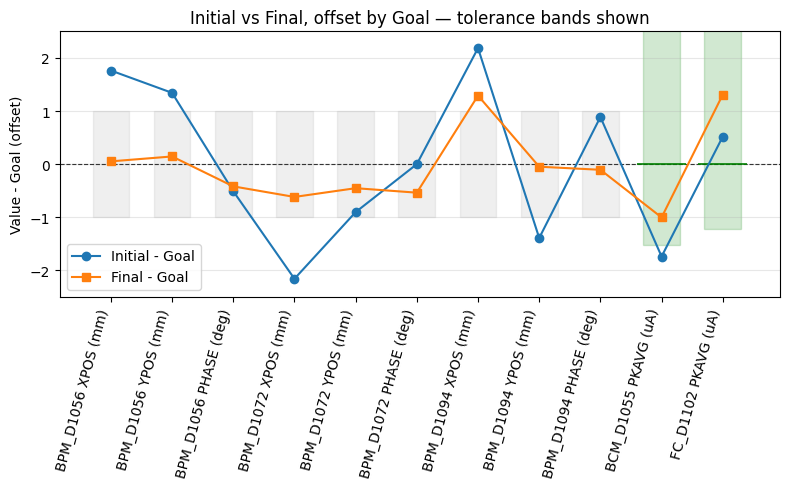

In [19]:
from matplotlib.patches import Rectangle

history = obj.history['objective_RDs']
goal  = obj.objective_goal
tolerance = obj.objective_norm

names = history['names']
vals = np.array(history['values'], dtype=float)  # shape (n_steps, n_vars)
n_steps, n_vars = vals.shape

initial = vals[0, :]
final = vals[-1, :]

# Build arrays for goal, threshold flags, tolerances
name_to_idx = {n: i for i, n in enumerate(names)}
goal_values = np.full(n_vars, np.nan)
is_threshold = np.zeros(n_vars, dtype=bool)   # True if goal is {'more than': v}
tol_arr = np.zeros(n_vars)

for n, idx in name_to_idx.items():
    # tolerance
    tol_arr[idx] = float(tolerance.get(n, 0.0))
    # goal
    g = goal.get(n, None)
    if g is None:
        goal_values[idx] = np.nan
    elif isinstance(g, dict):
        # expecting {'more than': value}
        if 'more than' in g:
            is_threshold[idx] = True
            goal_values[idx] = float(g['more than'])
        else:
            # unexpected dict -> leave NaN
            goal_values[idx] = np.nan
    else:
        goal_values[idx] = float(g)

# compute differences relative to goal (value - goal)
diff_initial = initial - goal_values
diff_final = final - goal_values

# x positions
x = np.arange(n_vars)
x_labels = names

# Plotting
fig, ax = plt.subplots(figsize=(max(8, n_vars*0.25), 5))

# Tolerance bands (centered at 0 for numeric goals).
# For numeric goals -> draw symmetric band [-tol, +tol].
# For 'more than' goals -> draw a band from 0 to +tol (visualize one-sided desired region).
band_width = 0.6
for xi in x:
    tol = tol_arr[int(xi)]
    if np.isnan(goal_values[int(xi)]):
        continue
    left = xi - band_width/2
    if is_threshold[int(xi)]:
        # one-sided: highlight from 0 up to +tol
        bottom = -tol
        height = 100*tol
        rect = Rectangle((left, bottom), band_width, height, alpha=0.18, color='green', zorder=0)
        ax.add_patch(rect)
        # also draw a thin line at y=0 to emphasize the threshold
        ax.hlines(0.0, xi - 0.4, xi + 0.4, colors='green', linewidth=1.2, zorder=2)
    else:
        bottom = -tol
        height = 2*tol
        rect = Rectangle((left, bottom), band_width, height, alpha=0.12, color='gray', zorder=0)
        ax.add_patch(rect)

# Plot initial and final diffs
ax.plot(x, diff_initial, marker='o', linestyle='-', label='Initial - Goal', zorder=3)
ax.plot(x, diff_final, marker='s', linestyle='-', label=f'Final - Goal', zorder=4)

# Markers for numeric goals and threshold goals (same markers but will annotate specially)
for xi in x:
    gi = goal_values[int(xi)]
    if np.isnan(gi):
        ax.text(xi, diff_final[int(xi)], " no goal", fontsize=7, ha='center', va='bottom', color='0.5')
        continue
    # annotate numeric difference value
    # ax.text(xi, diff_final[int(xi)], f'{diff_final[int(xi)]:+.3g}', fontsize=7, ha='center', va='bottom')

# Horizontal zero line (the goal)
ax.axhline(0.0, color='k', linewidth=0.8, linestyle='--', zorder=1)
x_labels = [simplify_label(n) for n in names]
# X ticks
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=75, ha='right')
ax.set_ylabel('Value - Goal (offset)')
ax.set_title('Initial vs Final, offset by Goal — tolerance bands shown')

# Legend and grid
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(-2.5,2.5)
plt.tight_layout()

# Compute and print which finals are within tolerance
within = np.full(n_vars, False)
for i in range(n_vars):
    if np.isnan(goal_values[i]):
        within[i] = False
    elif is_threshold[i]:
        # for 'more than' goals: consider final within if final >= goal (i.e. diff >= 0)
        # allow a small slack downward equal to tolerance: final >= goal - tol  (lenient)
        within[i] = (final[i] >= goal_values[i] - tol_arr[i])
    else:
        within[i] = (abs(diff_final[i]) <= tol_arr[i])

# Print summary in console
print("Summary (final relative to goal):")
for i, name in enumerate(names):
    if np.isnan(goal_values[i]):
        status = "NO GOAL"
    else:
        status = "WITHIN TOL" if within[i] else "OUTSIDE TOL"
    s = f"{name:40s}  final-goal = {diff_final[i]:+8.4g}   tol = {tol_arr[i]:6.4g}   {status}"
    print(s)

plt.savefig(logfile.replace('.json','_initVSfinal.png'),dpi=128)

In [22]:
obj.objective_goal

{'FE_MEBT:BPM_D1056:XPOS_RD': -0.4308420545214152,
 'FE_MEBT:BPM_D1056:YPOS_RD': 0.7113624983870361,
 'FE_MEBT:BPM_D1056:PHASE_RD': 77.66645930597238,
 'FE_MEBT:BPM_D1072:XPOS_RD': 0.43892044456095614,
 'FE_MEBT:BPM_D1072:YPOS_RD': 0.3980267777446268,
 'FE_MEBT:BPM_D1072:PHASE_RD': -25.237099624620456,
 'FE_MEBT:BPM_D1094:XPOS_RD': -0.24002164705455056,
 'FE_MEBT:BPM_D1094:YPOS_RD': -0.19312657326518465,
 'FE_MEBT:BPM_D1094:PHASE_RD': -14.651846578465333,
 'FE_MEBT:BCM_D1055:AVGPK_RD': {'more than': 30.3},
 'FE_MEBT:FC_D1102:PKAVG_RD': {'more than': 24.240000000000002}}

In [20]:
obj.objective_norm

{'FE_MEBT:BPM_D1056:XPOS_RD': 1,
 'FE_MEBT:BPM_D1056:YPOS_RD': 1,
 'FE_MEBT:BPM_D1056:PHASE_RD': 1,
 'FE_MEBT:BPM_D1072:XPOS_RD': 1,
 'FE_MEBT:BPM_D1072:YPOS_RD': 1,
 'FE_MEBT:BPM_D1072:PHASE_RD': 1,
 'FE_MEBT:BPM_D1094:XPOS_RD': 1,
 'FE_MEBT:BPM_D1094:YPOS_RD': 1,
 'FE_MEBT:BPM_D1094:PHASE_RD': 1,
 'FE_MEBT:BCM_D1055:AVGPK_RD': 1.5150000000000001,
 'FE_MEBT:FC_D1102:PKAVG_RD': 1.2120000000000002}

In [21]:
obj.objective_weight

{'FE_MEBT:BPM_D1056:XPOS_RD': 0.08695652173913045,
 'FE_MEBT:BPM_D1056:YPOS_RD': 0.08695652173913045,
 'FE_MEBT:BPM_D1056:PHASE_RD': 0.08695652173913045,
 'FE_MEBT:BPM_D1072:XPOS_RD': 0.04347826086956522,
 'FE_MEBT:BPM_D1072:YPOS_RD': 0.04347826086956522,
 'FE_MEBT:BPM_D1072:PHASE_RD': 0.04347826086956522,
 'FE_MEBT:BPM_D1094:XPOS_RD': 0.02173913043478261,
 'FE_MEBT:BPM_D1094:YPOS_RD': 0.02173913043478261,
 'FE_MEBT:BPM_D1094:PHASE_RD': 0.02173913043478261,
 'FE_MEBT:BCM_D1055:AVGPK_RD': 0.32608695652173914,
 'FE_MEBT:FC_D1102:PKAVG_RD': 0.2173913043478261}